# Models, Motifs, Influence

predict: SD1/(SD1+SD2)

TODO:
- display most influential motifs for each model/cell type
- Plot info content vs influence for each model/cell type
- Do TomTom search for each model/cell type
- Test on genomic data from HAL

In [1]:
%matplotlib inline
import glob
import sys
import os
import cPickle

sys.path.append(os.path.abspath('../src/'))
import nn_utils
import draw_logo
reload(draw_logo)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [197]:
path_base = '../data'
data_dirs = {'conv-max': '2017-04-14-models-2',
             'conv-avg': '2017-04-15-models-2',
             #'conv-max-500': '2017-04-27-models',
             #'conv-max-avg': '2017-04-28-models',
             #'conv-positional': '2017-05-01-models',
             'conv-recur-10': '2017-05-03-models'}
cell_types = ['HEPG2', 'MCF7', 'CHO', 'HELA', 'LNCAP', 'HEK']


In [198]:
motifs = {} # dict of model => cell type => motifs
influences = {} # dict of model => cell type => influence
info_contents = {}
for name, path in data_dirs.iteritems():
    motifs[name] = {}
    influences[name] = {}
    info_contents[name] = {}
    for c in cell_types:
        filter_paths = glob.glob(os.path.join(path_base, path, c + '-filters*'))
        if len(filter_paths) > 1:
            motifs[name][c] = np.zeros((len(filter_paths)*200, 6, 4))
            for i, p in enumerate(filter_paths):
                motifs[name][c][i*200:(i+1)*200,:,:] = np.load(p)
        else:
            motifs[name][c] = np.load(filter_paths[0])
        info_contents[name][c] = draw_logo.all_info_content(motifs[name][c])
        p2 = glob.glob(os.path.join(path_base, path, c + '-influence*'))
        if len(p2)==1:
            influences[name][c] = np.load(p2[0])
        else:
            pass

## Maximum Influence Motifs

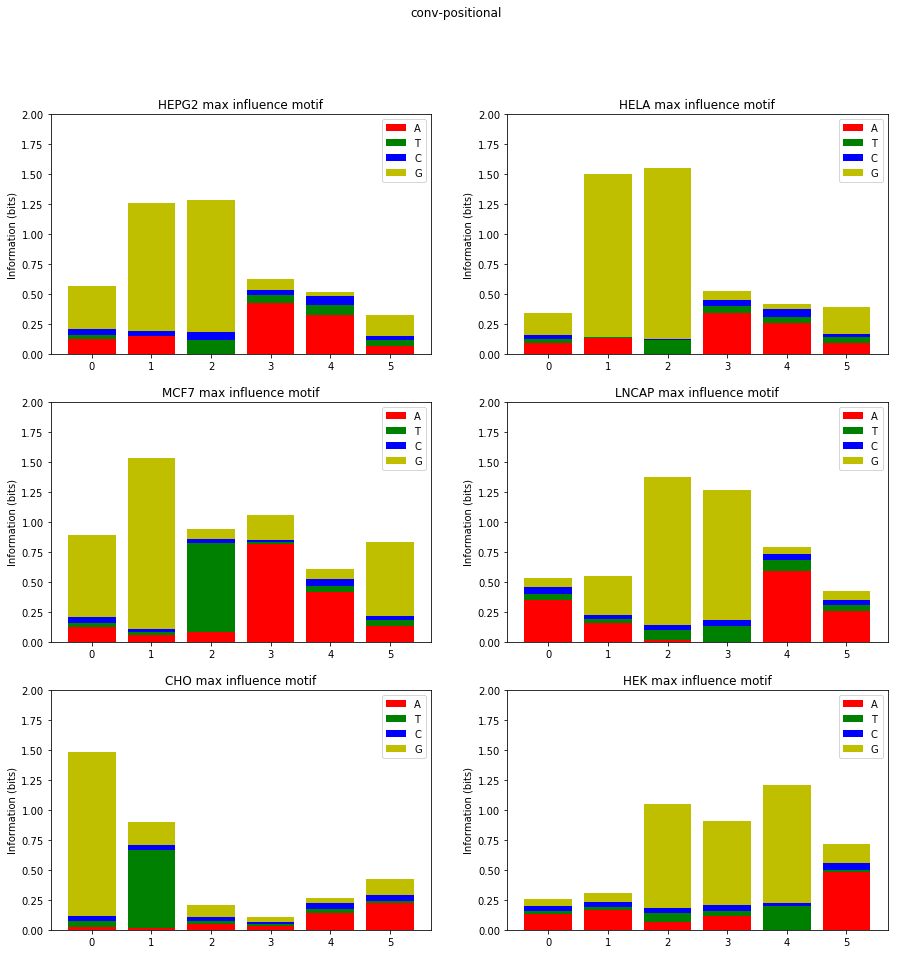

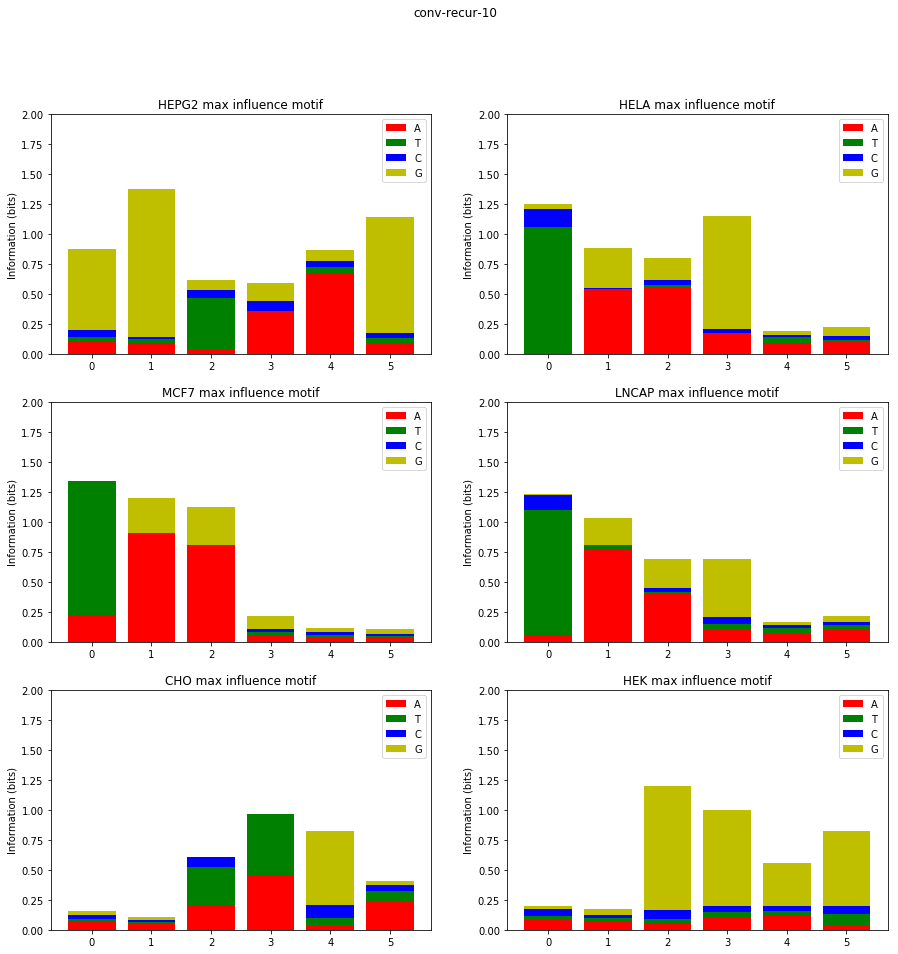

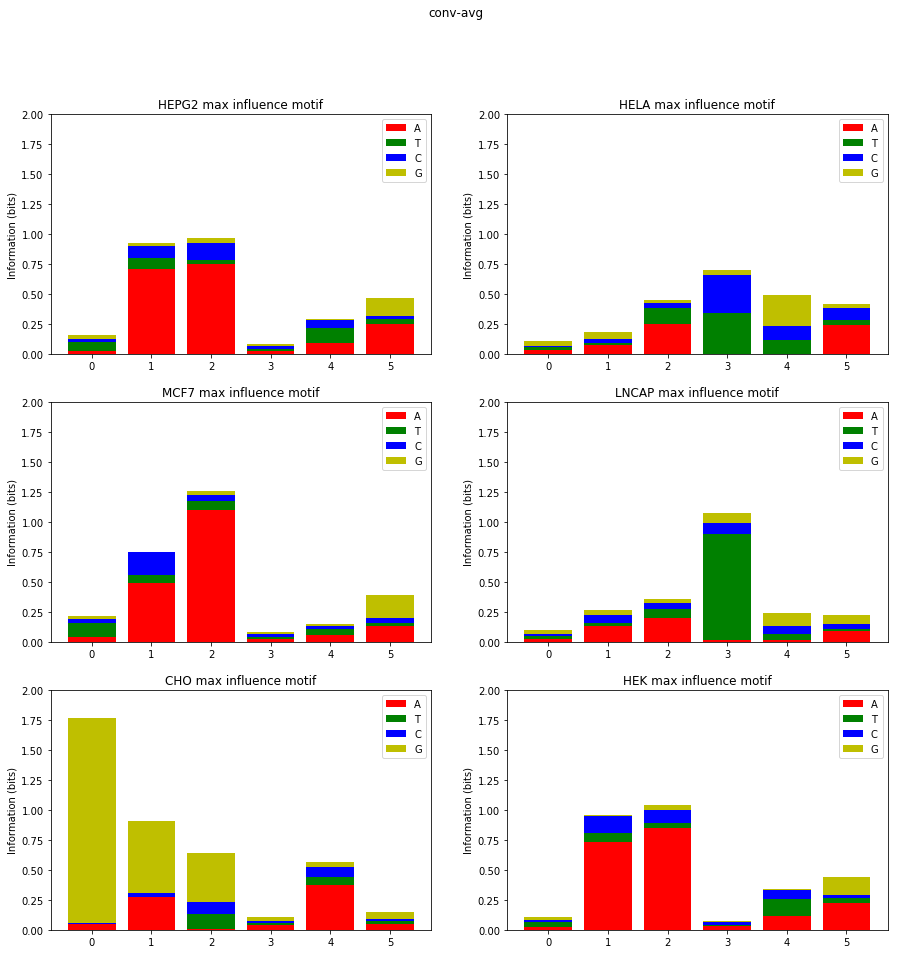

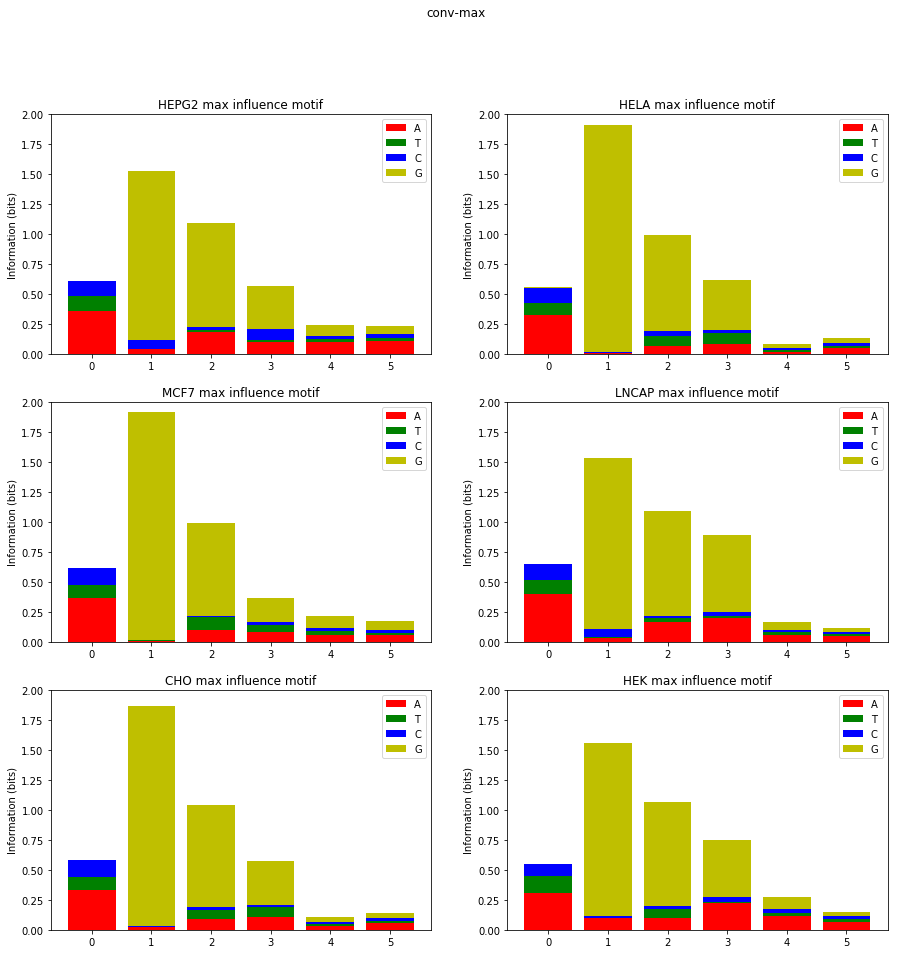

In [199]:
for m, infs in influences.iteritems():
    if len(infs) > 0:
        figs, axes = plt.subplots(3, 2, figsize=(15, 15))
        figs.suptitle(m)
    for i, c in enumerate(infs.keys()):
        indices = np.argsort(infs[c])
        max_influences = indices[-1:]
        max_influence_motifs = motifs[m][c][max_influences,:,:]
        draw_logo.draw_logo(max_influence_motifs[0], ax=axes[i%3, i/3])
        axes[i%3, i/3].set_title(c + ' max influence motif')
    


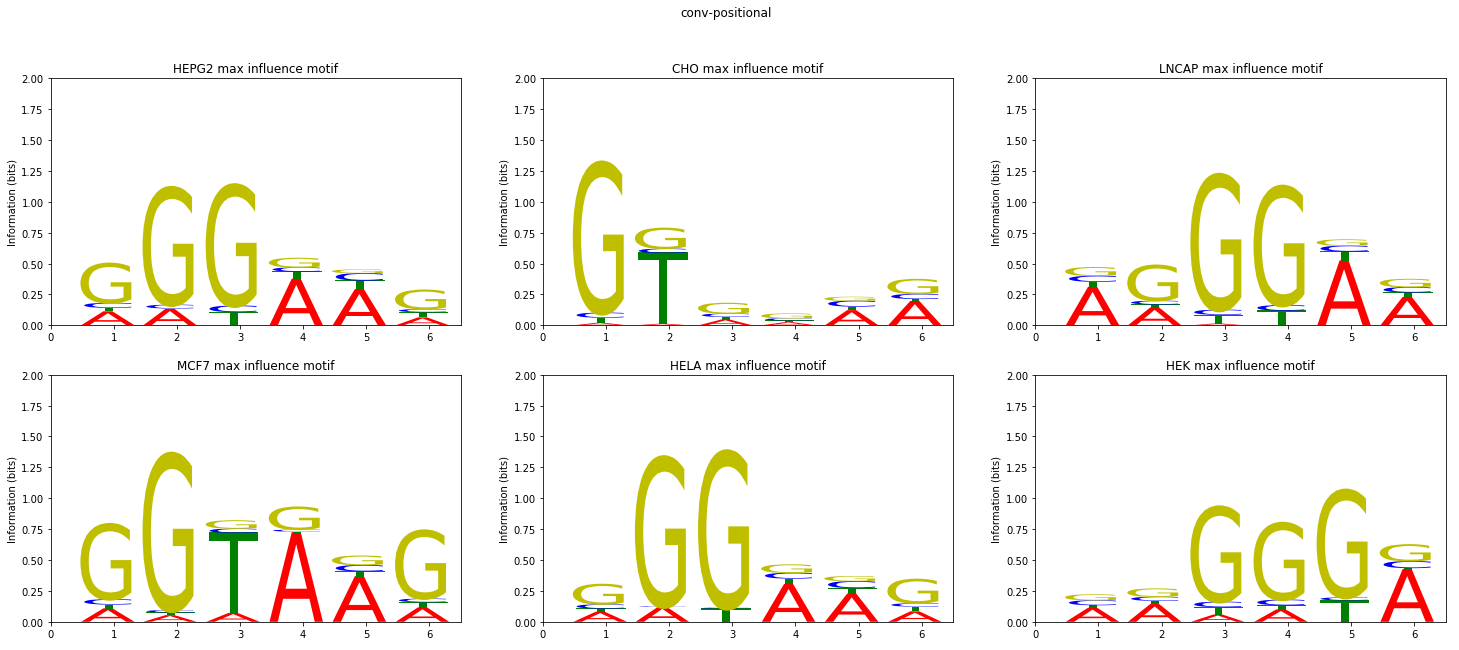

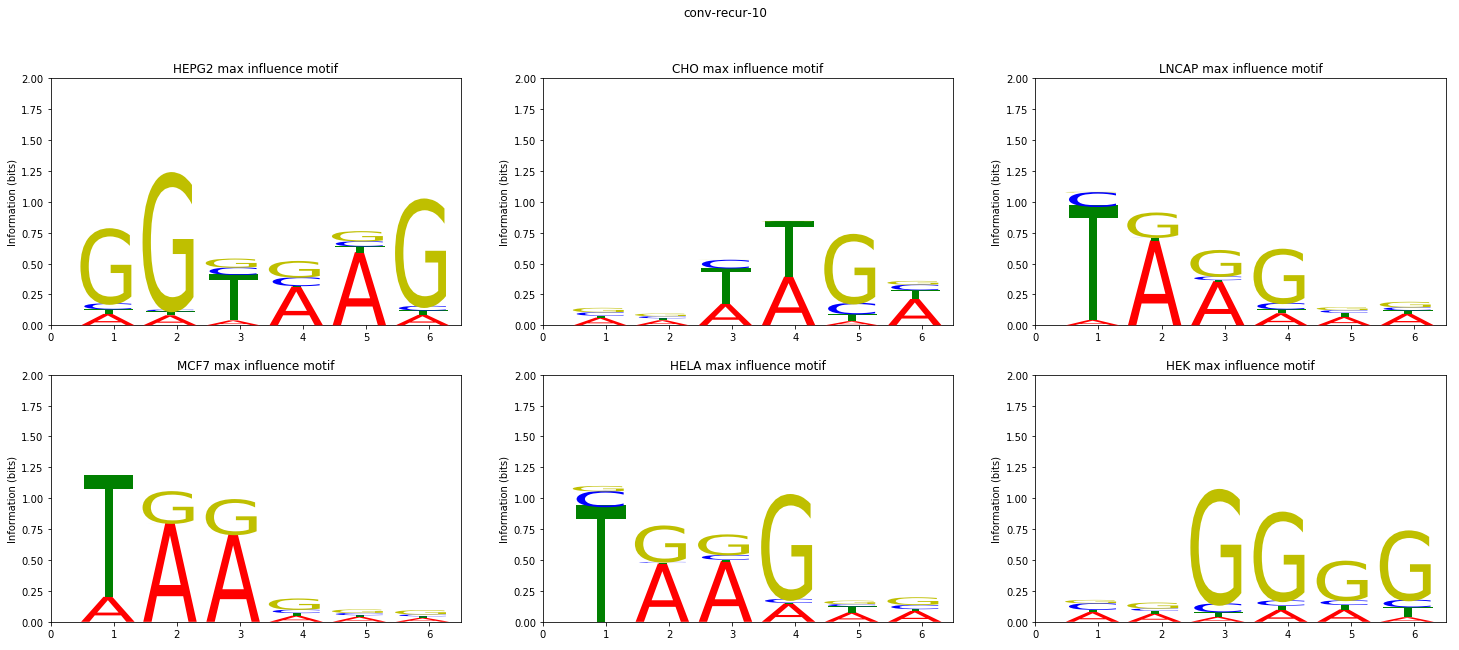

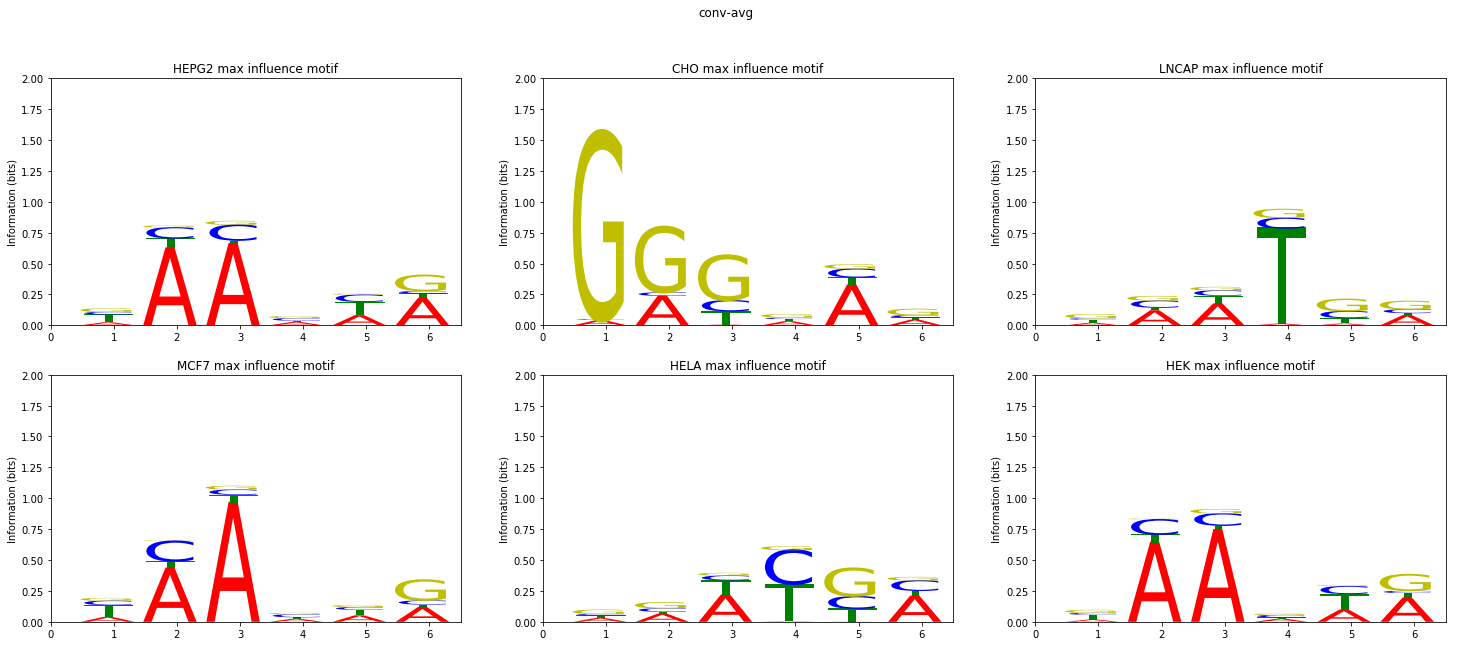

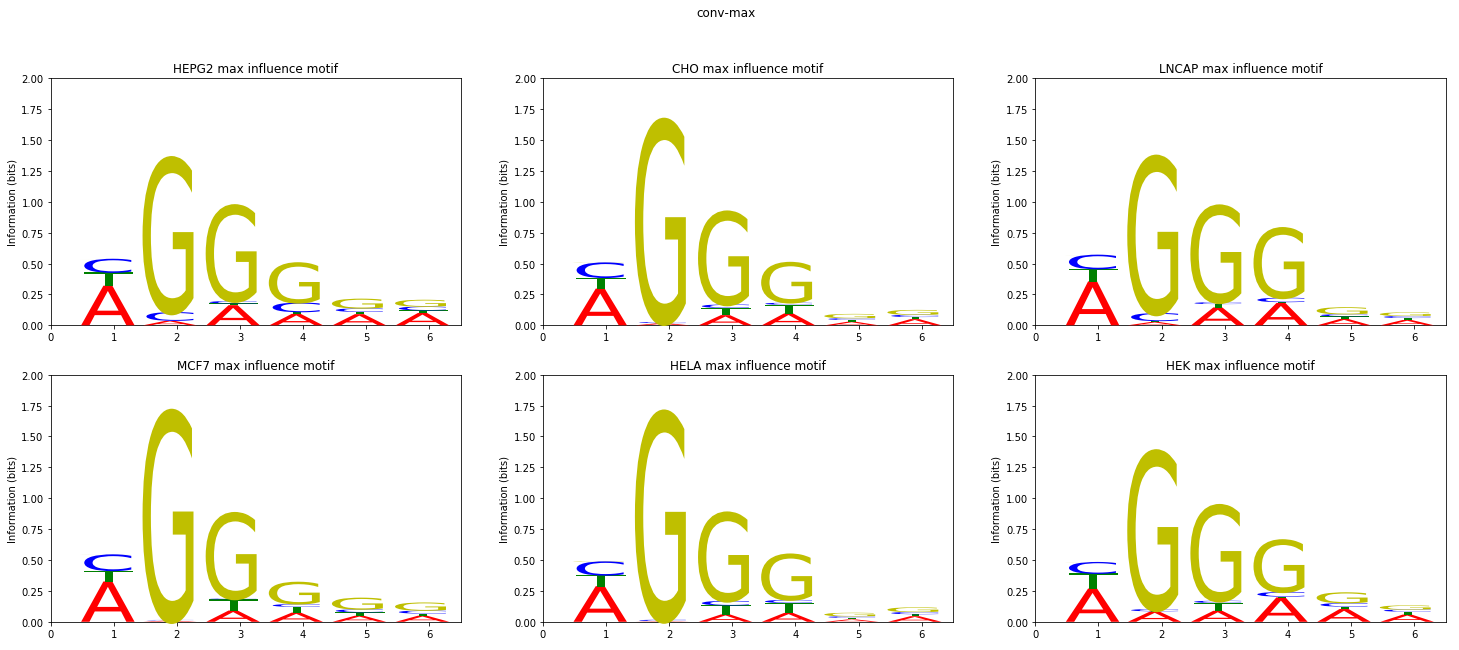

In [221]:
for m, infs in influences.iteritems():
    if len(infs) > 0:
        figs, axes = plt.subplots(2, 3, figsize=(25, 10))
        figs.suptitle(m)
    for i, c in enumerate(infs.keys()):
        indices = np.argsort(infs[c])
        max_influences = indices[-1:]
        max_influence_motifs = motifs[m][c][max_influences,:,:]
        draw_logo.draw_logo_2(max_influence_motifs[0], ax=axes[i%2, i/2])
        axes[i%2, i/2].set_title(c + ' max influence motif')

## Influence vs Information Content

In [201]:
info = {}
for name, path in data_dirs.iteritems():
    info[name] = {}
    for c in cell_types:
        info[name][c] = draw_logo.all_info_content(motifs[name][c])

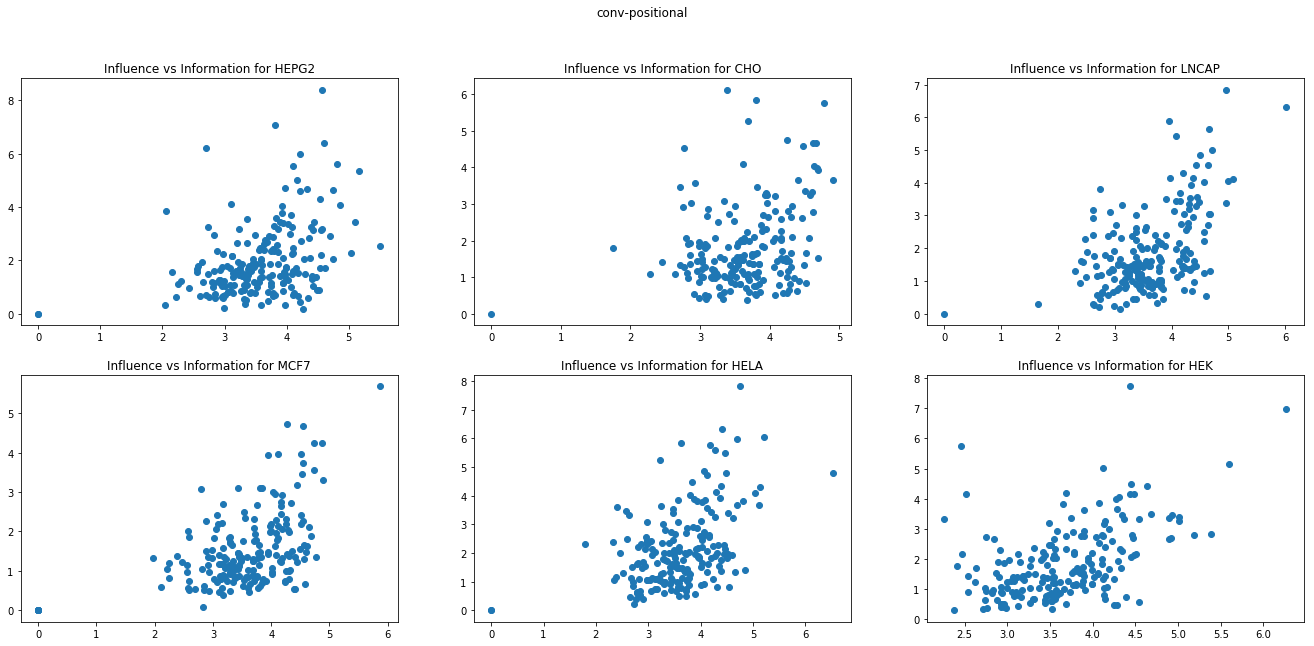

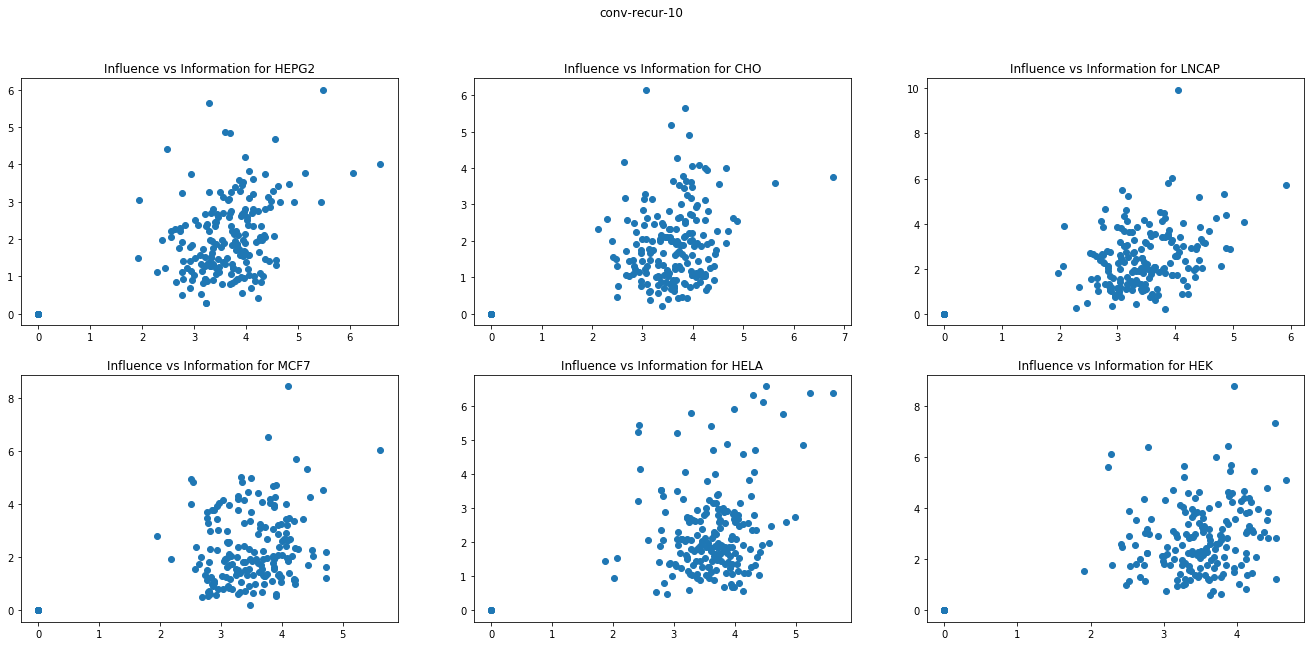

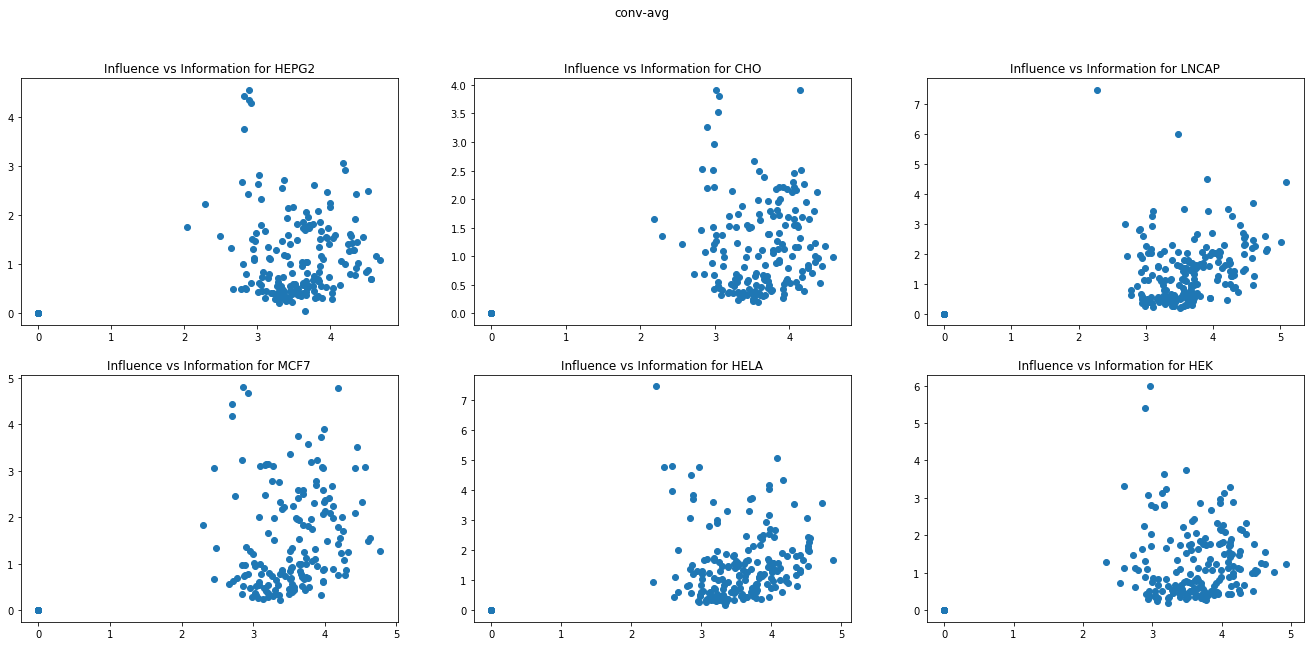

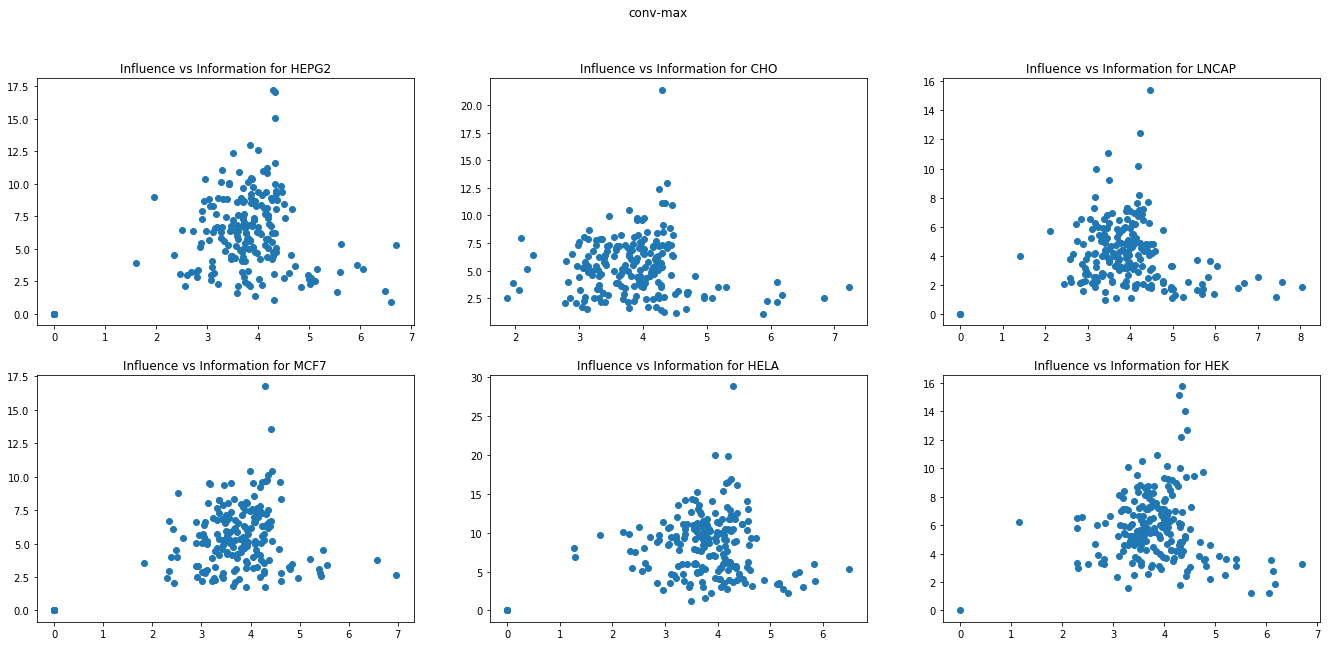

In [222]:
for m, infs in influences.iteritems():
    if len(infs) > 0:
        figs, axes = plt.subplots(2, 3, figsize=(23, 10))
        figs.suptitle(m)
    for i, c in enumerate(infs.keys()):
        axes[i%2, i/2].scatter(info[m][c], influences[m][c])
        axes[i%2, i/2].set_title('Influence vs Information for {0}'.format(c))

In [203]:
for m, infs in influences.iteritems():
    if len(infs) > 0:
        for i, c in enumerate(infs.keys()):
            cc = np.corrcoef(info[m][c], influences[m][c])
            print m, c, cc[0,1]
            

conv-positional HEPG2 0.401453979995
conv-positional MCF7 0.515676233095
conv-positional CHO 0.308279216015
conv-positional HELA 0.457600352458
conv-positional LNCAP 0.511066764874
conv-positional HEK 0.489994118228
conv-recur-10 HEPG2 0.534264293951
conv-recur-10 MCF7 0.48795419212
conv-recur-10 CHO 0.444156283699
conv-recur-10 HELA 0.346749053242
conv-recur-10 LNCAP 0.557760720434
conv-recur-10 HEK 0.594907491168
conv-avg HEPG2 0.312649886089
conv-avg MCF7 0.524112655734
conv-avg CHO 0.442426858473
conv-avg HELA 0.22332164876
conv-avg LNCAP 0.339994449673
conv-avg HEK 0.322685647487
conv-max HEPG2 0.169967754476
conv-max MCF7 0.361851411037
conv-max CHO -0.0722130274119
conv-max HELA 0.103150048035
conv-max LNCAP -0.0845976106067
conv-max HEK -0.0394246085881


## TomTom Motif Searches for Conv-Positional, Conv-Recur, Conv-max-avg models

In [11]:
motif_db_path = '../data/rna_motifs/rna_meme_db.txt'

In [12]:
import tomtom

In [204]:
for name, path in data_dirs.iteritems():
    for c in cell_types:
        motif_filename = c + '_motifs.txt'
        output_dir = os.path.join(path_base, path, c)
        retcode = tomtom.tomtom(motifs[name][c], motif_filename, output_dir, motif_db_path)
        print retcode

1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [205]:
matches = {}
for name, path in data_dirs.iteritems():
    matches[name] = {}
    for c in cell_types:
        output_path = os.path.join(path_base, path, c, 'tomtom.txt')
        matches[name][c] = pd.read_table(output_path)

In [53]:
matches['conv-max-avg']['HEK'].head()

#Query ID Target ID  Optimal offset   p-value   E-value   q-value  Overlap  \
0          0  M070_0.6               3  0.001109  0.011092  0.022184        5   
1          0  M352_0.6               3  0.015190  0.151904  0.151904        6   
2          1  M070_0.6               3  0.004730  0.047302  0.094605        5   
3          1  M352_0.6               0  0.011350  0.113501  0.113501        6   
4          2  M070_0.6               0  0.003847  0.038465  0.049450        6   

  Query consensus Target consensus Orientation  
0          AGAGGA         AGGAGAGG           +  
1          AGAGGA        AGGAGAGTA           +  
2          AGAAGA         AGGAGAGG           +  
3          AGAAGA        AGGAGAGTA           +  
4          AGGAGA         AGGAGAGG           +

In [54]:
matches['conv-recur']['HEK'].head()

#Query ID Target ID  Optimal offset   p-value   E-value   q-value  Overlap  \
0          2  M070_0.6               1  0.010967  0.109670  0.140267        6   
1          2  M352_0.6               3  0.014027  0.140267  0.140267        6   
2          4  M210_0.6               0  0.016896  0.168957  0.337915        6   
3          8  M210_0.6               1  0.010230  0.102301  0.130262        6   
4          8  M070_0.6               3  0.013026  0.130262  0.130262        5   

  Query consensus Target consensus Orientation  
0          GGAGGA         AGGAGAGG           +  
1          GGAGGA        AGGAGAGTA           +  
2          AGGTAA          TAGATAG           +  
3          AGAATG          TAGATAG           +  
4          AGAATG         AGGAGAGG           +

In [206]:
good_matches = {}
for name, path in data_dirs.iteritems():
    good_matches[name] = {}
    for c in cell_types:
        good_matches[name][c] = matches[name][c][matches[name][c]['q-value']<0.05]

In [207]:
good_matches['conv-recur-10']

{'CHO':      #Query ID Target ID  Optimal offset   p-value   E-value   q-value  \
 0            1  M070_0.6               2  0.000350  0.003501  0.007003   
 37          63  M070_0.6               2  0.000514  0.005143  0.010285   
 65         112  M070_0.6               3  0.000876  0.008757  0.017515   
 81         145  M070_0.6               0  0.001300  0.012999  0.025998   
 92         159  M016_0.6               1  0.000920  0.009197  0.018394   
 101        179  M070_0.6               3  0.002406  0.024058  0.048116   
 104        184  M070_0.6               1  0.000184  0.001835  0.003671   
 105        184  M352_0.6               1  0.002475  0.024746  0.024746   
 108        196  M352_0.6               0  0.002173  0.021733  0.030500   
 109        196  M070_0.6               0  0.003050  0.030500  0.030500   
 
      Overlap Query consensus Target consensus Orientation  
 0          6          GAGAGG         AGGAGAGG           +  
 37         6          GAGAAC         AGGAGA

In [22]:
{c: good_matches['conv-max'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M016_0.6', 'M070_0.6', 'M352_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HELA': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HEPG2': array(['M070_0.6', 'M352_0.6', 'M016_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6', 'M352_0.6', 'M016_0.6'], dtype=object),
 'MCF7': array(['M352_0.6', 'M160_0.6', 'M016_0.6', 'M070_0.6'], dtype=object)}

In [23]:
{c: good_matches['conv-avg'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M070_0.6', 'M352_0.6', 'M016_0.6', 'M210_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HELA': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HEPG2': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'MCF7': array(['M070_0.6', 'M352_0.6'], dtype=object)}

In [19]:
{c: good_matches['conv-recur'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HELA': array(['M070_0.6', 'M352_0.6'], dtype=object),
 'HEPG2': array(['M070_0.6', 'M016_0.6', 'M352_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6'], dtype=object),
 'MCF7': array(['M070_0.6', 'M352_0.6'], dtype=object)}

In [20]:
{c: matches['conv-max-avg'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M352_0.6', 'M070_0.6', 'M016_0.6', 'M237_0.6', 'M160_0.6',
        'M210_0.6', 'M138_0.6', 'M027_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M352_0.6', 'M016_0.6', 'M237_0.6', 'M210_0.6',
        'M138_0.6', 'M160_0.6'], dtype=object),
 'HELA': array(['M160_0.6', 'M070_0.6', 'M352_0.6', 'M210_0.6', 'M016_0.6',
        'M138_0.6', 'M027_0.6', 'M237_0.6'], dtype=object),
 'HEPG2': array(['M352_0.6', 'M070_0.6', 'M016_0.6', 'M237_0.6', 'M210_0.6',
        'M160_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6', 'M016_0.6', 'M352_0.6', 'M210_0.6', 'M237_0.6',
        'M160_0.6', 'M138_0.6'], dtype=object),
 'MCF7': array(['M070_0.6', 'M210_0.6', 'M352_0.6', 'M016_0.6', 'M160_0.6',
        'M138_0.6', 'M237_0.6'], dtype=object)}

In [21]:
{c: matches['conv-positional'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M070_0.6', 'M352_0.6', 'M016_0.6', 'M237_0.6', 'M210_0.6',
        'M160_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M210_0.6', 'M352_0.6', 'M138_0.6', 'M016_0.6',
        'M160_0.6', 'M237_0.6', 'M027_0.6'], dtype=object),
 'HELA': array(['M070_0.6', 'M352_0.6', 'M210_0.6', 'M016_0.6', 'M160_0.6'], dtype=object),
 'HEPG2': array(['M352_0.6', 'M070_0.6', 'M016_0.6', 'M210_0.6', 'M138_0.6',
        'M160_0.6', 'M237_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6', 'M352_0.6', 'M210_0.6', 'M138_0.6', 'M160_0.6',
        'M016_0.6', 'M237_0.6'], dtype=object),
 'MCF7': array(['M352_0.6', 'M210_0.6', 'M070_0.6', 'M016_0.6', 'M237_0.6'], dtype=object)}

In [68]:
{c: matches['conv-recur'][c]['Target ID'].unique() for c in cell_types}

{'CHO': array(['M070_0.6', 'M352_0.6', 'M210_0.6', 'M160_0.6', 'M016_0.6'], dtype=object),
 'HEK': array(['M070_0.6', 'M352_0.6', 'M210_0.6', 'M016_0.6', 'M237_0.6'], dtype=object),
 'HELA': array(['M070_0.6', 'M352_0.6', 'M016_0.6', 'M160_0.6', 'M237_0.6',
        'M210_0.6'], dtype=object),
 'HEPG2': array(['M070_0.6', 'M352_0.6', 'M160_0.6', 'M210_0.6', 'M016_0.6'], dtype=object),
 'LNCAP': array(['M070_0.6', 'M352_0.6', 'M210_0.6', 'M016_0.6', 'M160_0.6'], dtype=object),
 'MCF7': array(['M210_0.6', 'M070_0.6', 'M352_0.6', 'M016_0.6', 'M237_0.6',
        'M160_0.6'], dtype=object)}

In [71]:
# find IDs in actual file???
motif_db = pd.read_table('../data/rna_motifs/RBP_Information_all_motifs.txt')

In [72]:
motif_db.head()

RBP_ID Family_ID RSource_ID Motif_ID MSource_ID             DBID  \
0  T00060_0.6   F09_0.6   TS19_0.6        .          .  ENSG00000160917   
1  T00506_0.6   F15_0.6   TS19_0.6        .          .  ENSG00000086589   
2  T00507_0.6   F15_0.6   TS19_0.6        .          .  ENSG00000091009   
3  T00508_0.6   F15_0.6   TS19_0.6        .          .  ENSG00000139746   
4  T00509_0.6   F15_0.6   TS19_0.6        .          .  ENSG00000160201   

  RBP_Name   RBP_Species RBP_Status      Family_Name      ...       \
0    CPSF4  Homo_sapiens          N  CCCH ZF,CCHC ZF      ...        
1    RBM22  Homo_sapiens          N      CCCH ZF,RRM      ...        
2    RBM27  Homo_sapiens          N      CCCH ZF,RRM      ...        
3    RBM26  Homo_sapiens          N      CCCH ZF,RRM      ...        
4    U2AF1  Homo_sapiens          N      CCCH ZF,RRM      ...        

  MSource_Type  MSource_Author  MSource_Year PMID MSource_Version  \
0            .               .             .    .               .   
1            .               .             .    .               .   
2            .               .             .    .               .   
3            .               .             .    .               .   
4            .               .             .    .               .   

  RBPSource_Name            RBPSource_URL RBPSource_Year RBPSource_Month  \
0        Ensembl  http://www.ensembl.org/           2011             Oct   
1        Ensembl  http://www.ensembl.org/           2011             Oct   
2        Ensembl  http://www.ensembl.org/           2011             Oct   
3        Ensembl  http://www.ensembl.org/           2011             Oct   
4        Ensembl  http://www.ensembl.org/           2011             Oct   

  RBPSource_Day  
0            26  
1            26  
2            26  
3            26  
4            26  

[5 rows x 26 columns]

In [79]:
motif_db[motif_db.Motif_ID=='M070_0.6']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
458  T37299_0.6   F49_0.6   TS19_0.6  M070_0.6    MS2_0.6  ENSG00000161547   
508  T37328_0.6   F49_0.6   TS19_0.6  M070_0.6    MS2_0.6  ENSG00000180771   

            RBP_Name   RBP_Species RBP_Status Family_Name      ...       \
458            SRSF2  Homo_sapiens          D         RRM      ...        
508  ENSG00000180771  Homo_sapiens          I         RRM      ...        

    MSource_Type  MSource_Author  MSource_Year PMID MSource_Version  \
458   RNAcompete             Ray          2013  NaN             NaN   
508   RNAcompete             Ray          2013  NaN             NaN   

    RBPSource_Name            RBPSource_URL RBPSource_Year RBPSource_Month  \
458        Ensembl  http://www.ensembl.org/           2011             Oct   
508        Ensembl  http://www.ensembl.org/           2011             Oct   

    RBPSource_Day  
458            26  
508            26  

[2 rows x 26 columns]

In [80]:
motif_db[motif_db.Motif_ID=='M352_0.6']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
461  T37299_0.6   F49_0.6   TS19_0.6  M352_0.6    MS1_0.6  ENSG00000161547   
511  T37328_0.6   F49_0.6   TS19_0.6  M352_0.6    MS1_0.6  ENSG00000180771   

            RBP_Name   RBP_Species RBP_Status Family_Name      ...       \
461            SRSF2  Homo_sapiens          D         RRM      ...        
511  ENSG00000180771  Homo_sapiens          I         RRM      ...        

    MSource_Type  MSource_Author  MSource_Year      PMID MSource_Version  \
461        RBPDB            Cook          2011  21036867          v1.2.1   
511        RBPDB            Cook          2011  21036867          v1.2.1   

    RBPSource_Name            RBPSource_URL RBPSource_Year RBPSource_Month  \
461        Ensembl  http://www.ensembl.org/           2011             Oct   
511        Ensembl  http://www.ensembl.org/           2011             Oct   

    RBPSource_Day  
461            26  
511            26  

[2 rows x 26 columns]

In [81]:
motif_db[motif_db.Motif_ID=='M016_0.6']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
136  T18787_0.6   F35_0.6   TS19_0.6  M016_0.6    MS2_0.6  ENSG00000102081   

    RBP_Name   RBP_Species RBP_Status Family_Name      ...      MSource_Type  \
136     FMR1  Homo_sapiens          D          KH      ...        RNAcompete   

     MSource_Author  MSource_Year PMID MSource_Version RBPSource_Name  \
136             Ray          2013  NaN             NaN        Ensembl   

               RBPSource_URL RBPSource_Year RBPSource_Month RBPSource_Day  
136  http://www.ensembl.org/           2011             Oct            26  

[1 rows x 26 columns]

In [82]:
motif_db[motif_db.Motif_ID=='M210_0.6']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
436  T37286_0.6   F49_0.6   TS19_0.6  M210_0.6    MS2_0.6  ENSG00000152795   

    RBP_Name   RBP_Species RBP_Status Family_Name      ...      MSource_Type  \
436   HNRPDL  Homo_sapiens          I         RRM      ...        RNAcompete   

     MSource_Author  MSource_Year PMID MSource_Version RBPSource_Name  \
436             Ray          2013  NaN             NaN        Ensembl   

               RBPSource_URL RBPSource_Year RBPSource_Month RBPSource_Day  
436  http://www.ensembl.org/           2011             Oct            26  

[1 rows x 26 columns]

In [83]:
motif_db[motif_db.Motif_ID=='M160_0.6']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
151  T18797_0.6   F35_0.6   TS19_0.6  M160_0.6    MS2_0.6  ENSG00000121774   

    RBP_Name   RBP_Species RBP_Status Family_Name      ...      MSource_Type  \
151  KHDRBS1  Homo_sapiens          D          KH      ...        RNAcompete   

     MSource_Author  MSource_Year PMID MSource_Version RBPSource_Name  \
151             Ray          2013  NaN             NaN        Ensembl   

               RBPSource_URL RBPSource_Year RBPSource_Month RBPSource_Day  
151  http://www.ensembl.org/           2011             Oct            26  

[1 rows x 26 columns]

In [85]:
motif_db[motif_db.RBP_Name=='RBFOX2']

RBP_ID Family_ID RSource_ID  Motif_ID MSource_ID             DBID  \
283  T37195_0.6   F49_0.6   TS19_0.6  M017_0.6    MS2_0.6  ENSG00000100320   
284  T37195_0.6   F49_0.6   TS19_0.6  M118_0.6    MS2_0.6  ENSG00000100320   
285  T37195_0.6   F49_0.6   TS19_0.6  M159_0.6    MS2_0.6  ENSG00000100320   
286  T37195_0.6   F49_0.6   TS19_0.6  M297_0.6    MS1_0.6  ENSG00000100320   
287  T37195_0.6   F49_0.6   TS19_0.6  M298_0.6    MS1_0.6  ENSG00000100320   

    RBP_Name   RBP_Species RBP_Status Family_Name      ...      MSource_Type  \
283   RBFOX2  Homo_sapiens          I         RRM      ...        RNAcompete   
284   RBFOX2  Homo_sapiens          I         RRM      ...        RNAcompete   
285   RBFOX2  Homo_sapiens          I         RRM      ...        RNAcompete   
286   RBFOX2  Homo_sapiens          I         RRM      ...             RBPDB   
287   RBFOX2  Homo_sapiens          I         RRM      ...             RBPDB   

     MSource_Author  MSource_Year      PMID MSource_Version RBPSource_Name  \
283             Ray          2013       NaN             NaN        Ensembl   
284             Ray          2013       NaN             NaN        Ensembl   
285             Ray          2013       NaN             NaN        Ensembl   
286            Cook          2011  21036867          v1.2.1        Ensembl   
287            Cook          2011  21036867          v1.2.1        Ensembl   

               RBPSource_URL RBPSource_Year RBPSource_Month RBPSource_Day  
283  http://www.ensembl.org/           2011             Oct            26  
284  http://www.ensembl.org/           2011             Oct            26  
285  http://www.ensembl.org/           2011             Oct            26  
286  http://www.ensembl.org/           2011             Oct            26  
287  http://www.ensembl.org/           2011             Oct            26  

[5 rows x 26 columns]

In [88]:
motif_db[motif_db.Motif_ID=='M138_0.6']

Empty DataFrame
Columns: [RBP_ID, Family_ID, RSource_ID, Motif_ID, MSource_ID, DBID, RBP_Name, RBP_Species, RBP_Status, Family_Name, RBDs, RBD_Count, Cutoff, DBID.1, Motif_Type, MSource_Identifier, MSource_Type, MSource_Author, MSource_Year, PMID, MSource_Version, RBPSource_Name, RBPSource_URL, RBPSource_Year, RBPSource_Month, RBPSource_Day]
Index: []

[0 rows x 26 columns]

## Genomic data

In [80]:
import genomic_data
reload(genomic_data)

from keras.models import model_from_json

from sklearn.metrics import r2_score

In [86]:
wt_seqs, mut_seqs, wt_psi, hal_dpsi, actual_dpsi = genomic_data.load_hal_test_data()

In [208]:
models = {}
for name, path in data_dirs.iteritems():
    models[name] = {}
    for c in cell_types:
        model_path = os.path.join(path_base, path, c + '.json')
        weights_path = os.path.join(path_base, path, c + '.h5')
        with open(model_path) as f:
            models[name][c] = model_from_json(f.read())
        models[name][c].load_weights(weights_path)

In [209]:
preds = {}
for name, path in data_dirs.iteritems():
    if 'positional' not in name:
        preds[name] = {}
        for c in cell_types:
            m = models[name][c]
            preds[name][c] = genomic_data.get_delta_psis(m, wt_seqs, mut_seqs, wt_psi)

In [210]:
r2_vals = {}
for name, path in data_dirs.iteritems():
    if 'positional' not in name:
        r2_vals[name] = {}
        for c in cell_types:
            r2_vals[name][c] = max(r2_score(preds[name][c], actual_dpsi), r2_score(actual_dpsi, preds[name][c]))

In [211]:
r2_vals

{'conv-avg': {'CHO': 0.076170343344424962,
  'HEK': 0.081678252452775602,
  'HELA': 0.083696366707038949,
  'HEPG2': 0.083144938710782657,
  'LNCAP': 0.083596486414350579,
  'MCF7': 0.086597421696421817},
 'conv-max': {'CHO': -0.038190408282466004,
  'HEK': -0.013551755766647577,
  'HELA': -0.078266292566406159,
  'HEPG2': -0.038161241710444882,
  'LNCAP': -0.076267687688889696,
  'MCF7': 0.0069353133173033488},
 'conv-max-500': {'CHO': -0.060861891689962366,
  'HEK': -0.097515782479040691,
  'HELA': -0.0716062906910091,
  'HEPG2': -1.8565816223503617e-05,
  'LNCAP': -0.051634565698312818,
  'MCF7': -0.019997137676922794},
 'conv-max-avg': {'CHO': 0.004784401631339974,
  'HEK': -0.032873837940065487,
  'HELA': -0.049295811689279434,
  'HEPG2': 0.031637493592916899,
  'LNCAP': -0.042107238624128573,
  'MCF7': 0.0063733285720726229},
 'conv-recur-10': {'CHO': -0.073484502076730962,
  'HEK': -0.45963198978604169,
  'HELA': -0.12583830257344752,
  'HEPG2': -0.067800019424940627,
  'LNCAP':

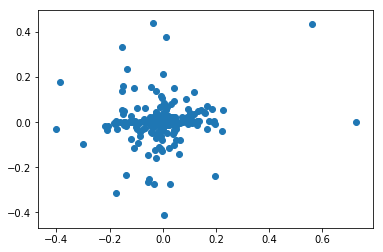

In [212]:
plt.scatter(actual_dpsi, preds['conv-recur-10']['HEK'])

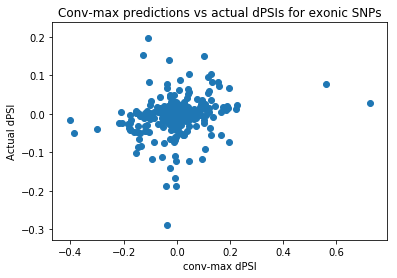

In [148]:
plt.scatter(actual_dpsi, preds['conv-max']['HEK'])
plt.title('Conv-max predictions vs actual dPSIs for exonic SNPs')
plt.ylabel('Actual dPSI')
plt.xlabel('conv-max dPSI')

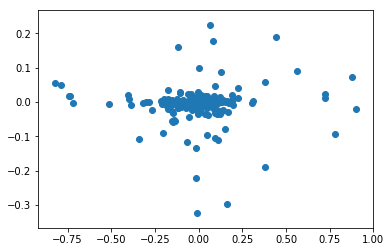

In [31]:
plt.scatter(actual_dpsi, preds['conv-max-avg']['HEK'])

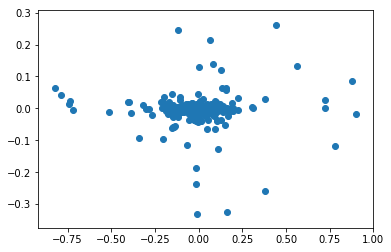

In [107]:
plt.scatter(actual_dpsi, preds['conv-max-500']['HEK'])

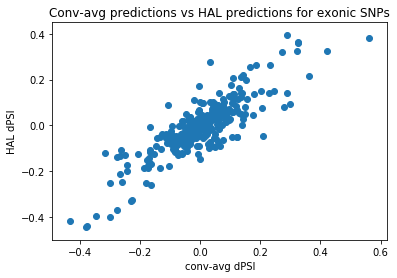

In [189]:
plt.scatter(hal_dpsi, np.array(preds['conv-avg']['HEK'])*np.array([len(s[0])/25.0 for s in mut_seqs]))
plt.title('Conv-avg predictions vs HAL predictions for exonic SNPs')
plt.ylabel('HAL dPSI')
plt.xlabel('conv-avg dPSI')

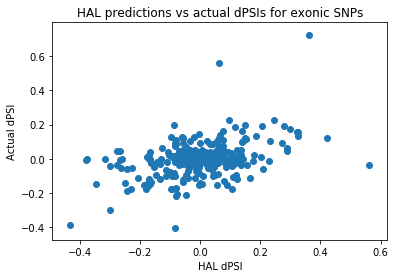

In [154]:
plt.scatter(hal_dpsi, actual_dpsi)
plt.title('HAL predictions vs actual dPSIs for exonic SNPs')
plt.ylabel('Actual dPSI')
plt.xlabel('HAL dPSI')

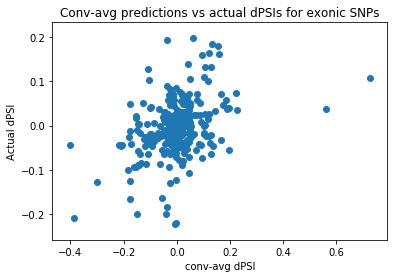

In [95]:
plt.scatter(actual_dpsi, np.array(preds['conv-avg']['HEK'])*np.array([len(s[0])/50.0 for s in mut_seqs]))
plt.title('Conv-avg predictions vs actual dPSIs for exonic SNPs')
plt.ylabel('Actual dPSI')
plt.xlabel('conv-avg dPSI')

In [90]:
preds_simple = {}
for name, path in data_dirs.iteritems():
    if 'positional' not in name:
        preds_simple[name] = {}
        for c in cell_types:
            m = models[name][c]
            preds_simple[name][c] = genomic_data.get_dpsi_simple(m, wt_seqs, mut_seqs, wt_psi)

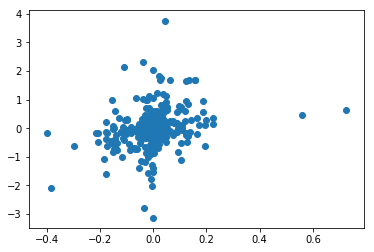

In [91]:
plt.scatter(actual_dpsi, preds_simple['conv-avg']['HEK']*20)

In [122]:
r2_score(actual_dpsi, np.array(preds['conv-avg']['HEK'])*np.array([len(s[0])/50.0 for s in mut_seqs]))


0.10516164829181818

In [123]:
r2_score(hal_dpsi, np.array(preds['conv-avg']['HEK'])*np.array([len(s[0])/50.0 for s in mut_seqs]))


0.58936901280523124

In [124]:
r2_score(actual_dpsi, hal_dpsi)

-0.50792241675312355

In [125]:
r2_score(hal_dpsi, actual_dpsi)

0.060103344615187959

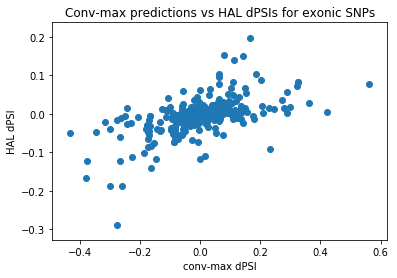

In [149]:
plt.scatter(hal_dpsi, preds['conv-max']['HEK'])
plt.title('Conv-max predictions vs HAL dPSIs for exonic SNPs')
plt.ylabel('HAL dPSI')
plt.xlabel('conv-max dPSI')

In [136]:
mean_preds = {}
for p in preds.keys():
    model_preds = [x for name, x in preds[p].iteritems()]
    model_preds = np.vstack(model_preds)
    mean_preds[p] = np.mean(model_preds, 0)

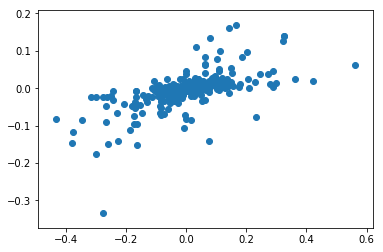

In [139]:
plt.scatter(hal_dpsi, mean_preds['conv-max'])

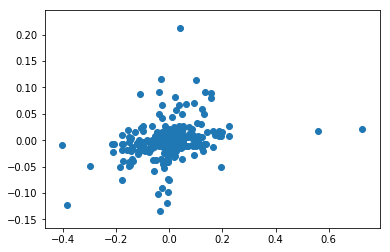

In [146]:
plt.scatter(actual_dpsi, mean_preds['conv-avg'])

In [144]:
r2_score(actual_dpsi, mean_preds['conv-avg'])

0.083849865976196591

In [147]:
r2_score(hal_dpsi, mean_preds['conv-avg'])

0.28772255044710249

In [153]:
r2_score(actual_dpsi, mean_preds['conv-max'])

0.00016890902468780222

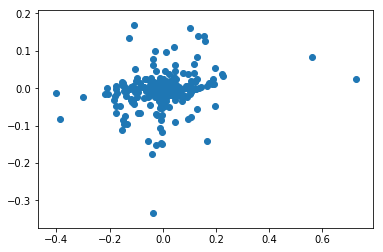

In [151]:
plt.scatter(actual_dpsi, mean_preds['conv-max'])

In [160]:
# TODO: try weighted model averaging- weigh by r^2 on test set
test_r2 = {}
for name, path in data_dirs.iteritems():
    r2_path = os.path.join(path_base, path, 'r2.txt')
    r2_table = pd.read_table(r2_path, header=None)
    test_r2[name] = r2_table

In [175]:
mean_preds_weighted = {}
for p in preds.keys():
    model_preds = [x for name, x in preds[p].iteritems()]
    model_preds = np.vstack(model_preds)
    mean_preds_weighted[p] = np.average(model_preds, 0, weights=test_r2[p][1]**0.5)

In [176]:
r2_score(actual_dpsi, mean_preds_weighted['conv-avg'])

0.083770761508748959

In [177]:
r2_score(actual_dpsi, mean_preds_weighted['conv-max'])

0.0010160394732942057

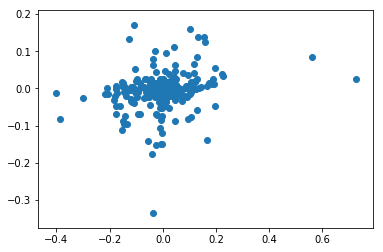

In [178]:
plt.scatter(actual_dpsi, mean_preds_weighted['conv-max'])

Conclusion: weighted averaging doesn't do much good

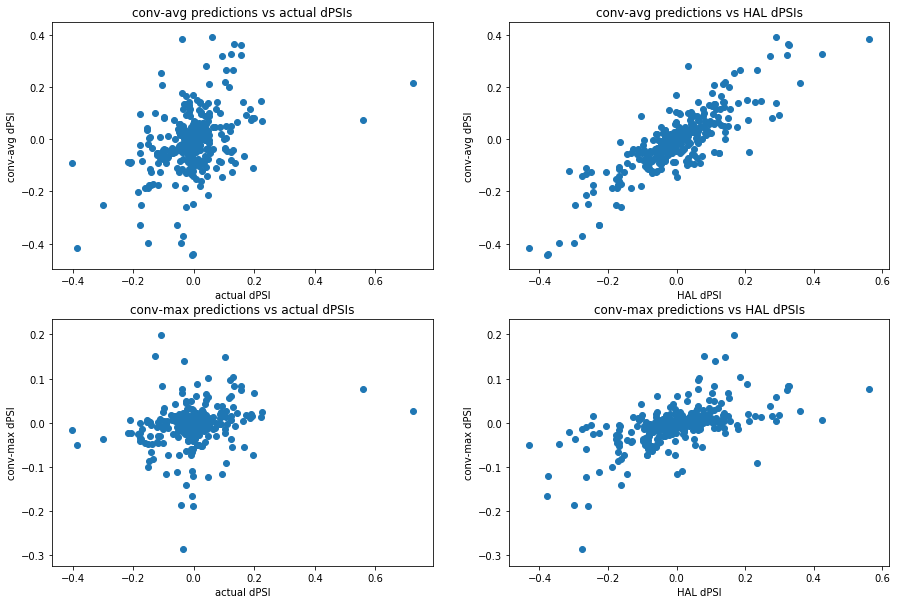

In [192]:
figs, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, m in enumerate(['conv-avg', 'conv-max']):
    if m=='conv-avg':
        axes[i, 0].scatter(actual_dpsi, preds[m]['HEK']*np.array([len(s[0])/25.0 for s in mut_seqs]))
    else:
        axes[i, 0].scatter(actual_dpsi, preds[m]['HEK'])    
    axes[i, 0].set_title(m + ' predictions vs actual dPSIs')
    axes[i, 0].set_xlabel('actual dPSI')
    axes[i, 0].set_ylabel(m + ' dPSI')
    if m=='conv-avg':
        axes[i, 1].scatter(hal_dpsi, preds[m]['HEK']*np.array([len(s[0])/25.0 for s in mut_seqs]))
    else:
        axes[i, 1].scatter(hal_dpsi, preds[m]['HEK']) 
    axes[i, 1].set_title(m + ' predictions vs HAL dPSIs')
    axes[i, 1].set_xlabel('HAL dPSI')
    axes[i, 1].set_ylabel(m + ' dPSI')

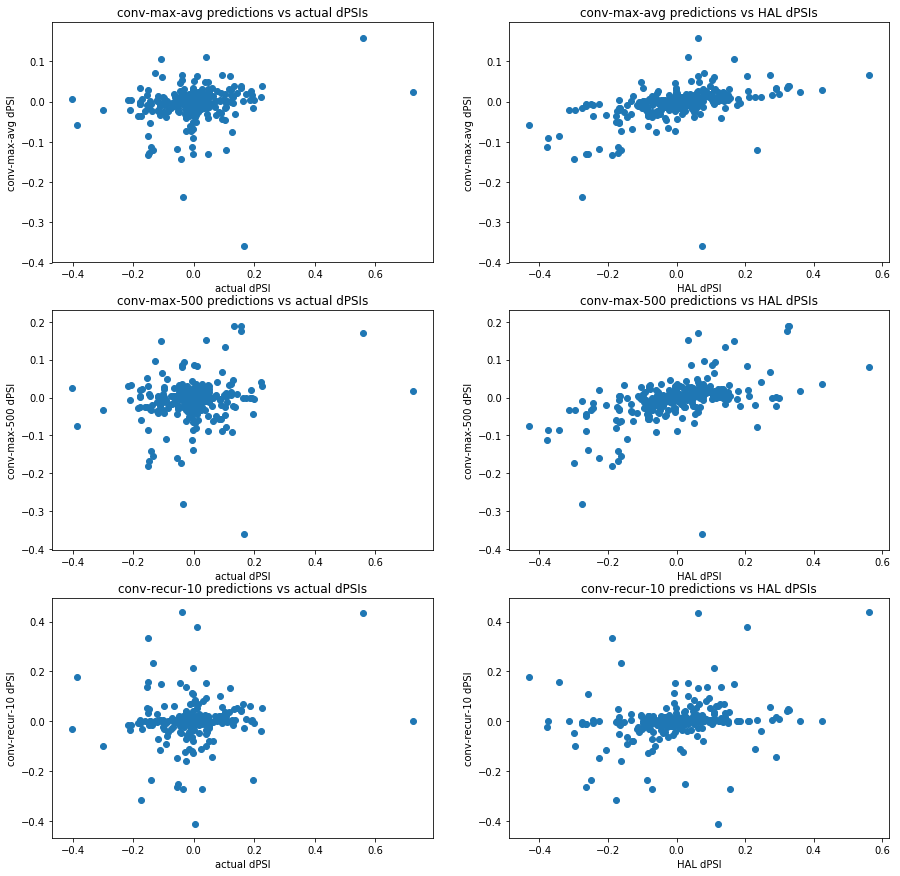

In [214]:
figs, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, m in enumerate(['conv-max-avg', 'conv-max-500', 'conv-recur-10']):
    if m=='conv-avg':
        axes[i, 0].scatter(actual_dpsi, preds[m]['HEK']*np.array([len(s[0])/25.0 for s in mut_seqs]))
    else:
        axes[i, 0].scatter(actual_dpsi, preds[m]['HEK'])    
    axes[i, 0].set_title(m + ' predictions vs actual dPSIs')
    axes[i, 0].set_xlabel('actual dPSI')
    axes[i, 0].set_ylabel(m + ' dPSI')
    if m=='conv-avg':
        axes[i, 1].scatter(hal_dpsi, preds[m]['HEK']*np.array([len(s[0])/25.0 for s in mut_seqs]))
    else:
        axes[i, 1].scatter(hal_dpsi, preds[m]['HEK']) 
    axes[i, 1].set_title(m + ' predictions vs HAL dPSIs')
    axes[i, 1].set_xlabel('HAL dPSI')
    axes[i, 1].set_ylabel(m + ' dPSI')